In [1]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import matplotlib.gridspec as gridspec
import random
from astroML.correlation import two_point
from scipy.optimize import curve_fit

z="{:.2f}".format(0.20) # repeat for all redshifts
cdm_galaxy = h5py.File('Data/n/home07/sbose/COLOR_CDM_Galaxies_z'+z+'.hdf5', 'r')
wdm_galaxy = h5py.File('Data/n/home07/sbose/COLOR_WDM_Galaxies_z'+z+'.hdf5', 'r')

print(cdm_galaxy,wdm_galaxy)

<HDF5 file "COLOR_CDM_Galaxies_z0.20.hdf5" (mode r)> <HDF5 file "COLOR_WDM_Galaxies_z0.20.hdf5" (mode r)>


# Access the masses and positions of CDM and WDM galaxies

In [2]:
# Access mass/position for wdm/cdm
print(list(cdm_galaxy.keys()),list(wdm_galaxy.keys()))

cdm_galaxy_color = cdm_galaxy['Colour'][:]
cdm_galaxy_position = cdm_galaxy['GalaxyPos'][:]
cdm_galaxy_mass = cdm_galaxy['StellarMass'][:]

wdm_galaxy_color = wdm_galaxy['Colour'][:]
wdm_galaxy_position = wdm_galaxy['GalaxyPos'][:]
wdm_galaxy_mass = wdm_galaxy['StellarMass'][:]

cdm_galaxy_color, cdm_galaxy_position, cdm_galaxy_mass, 
wdm_galaxy_color, wdm_galaxy_position, wdm_galaxy_mass

['Colour', 'GalaxyPos', 'IsCentral', 'StellarMass'] ['Colour', 'GalaxyPos', 'IsCentral', 'StellarMass']


(array([0.26351547, 0.26975822, 0.55730152, ..., 0.60256481, 0.60255599,
        0.60209143]), array([[18.13657761, 80.13793945, 52.1907692 ],
        [20.0150547 , 78.72826385, 53.95800018],
        [20.30582809, 79.4005127 , 53.66751862],
        ...,
        [78.52874756, 83.88411713, 62.66805267],
        [97.82990265, 36.0692482 , 37.34383011],
        [ 7.79859877, 48.99835968, 51.00095749]]), array([2.18818500e+06, 3.09918325e+06, 8.09408625e+05, ...,
        1.59784888e+03, 1.56134949e+03, 1.61065710e+03]))

# Compute the galaxy positions at fixed abundance
### Send the galaxy positions to Odyssey at n =  $\sim$0.33, $\sim$0.14, and 0.03 Galaxy/Mpc$^3$

In [3]:
# sort in order of descending mass
cdm_ind = sorted(range(len(cdm_galaxy_mass)), key=lambda k: cdm_galaxy_mass[k], reverse = True)
wdm_ind = sorted(range(len(wdm_galaxy_mass)), key=lambda k: wdm_galaxy_mass[k], reverse = True)

In [4]:
# iterate through each galaxy number density
for n in [326952,136834,30000]:
    
    # label the galaxy positions correctly
    label="_galaxy_position_z"+z+"_n{:.2f}".format(n/100**3)
    
    # save the galaxy positions
    np.savetxt("Calculations/cdm"+label+".txt", cdm_galaxy_position[cdm_ind[:n]], fmt = "%f %f %f")
    np.savetxt("Calculations/wdm"+label+".txt", wdm_galaxy_position[wdm_ind[:n]], fmt = "%f %f %f")

### Split the data by color!

In [5]:
# define the red and blue galaxies for CDM
cdm_blue = np.array(cdm_galaxy_color)[np.where(cdm_galaxy_color < 0.5)]
cdm_red = np.array(cdm_galaxy_color)[np.where(cdm_galaxy_color > 0.5)]

# define the red and blue galaxies for WDM
wdm_blue = np.array(wdm_galaxy_color)[np.where(wdm_galaxy_color < 0.5)]
wdm_red = np.array(wdm_galaxy_color)[np.where(wdm_galaxy_color > 0.5)]

In [6]:
# sort the blue galaxies in order of descending mass
cdm_blue_ind = sorted(range(len(cdm_blue)), key=lambda k: cdm_galaxy_mass[k], reverse = True)
wdm_blue_ind = sorted(range(len(wdm_blue)), key=lambda k: wdm_galaxy_mass[k], reverse = True)

# sort the red galaxies in order of descending mass
cdm_red_ind = sorted(range(len(cdm_red)), key=lambda k: cdm_galaxy_mass[k], reverse = True)
wdm_red_ind = sorted(range(len(wdm_red)), key=lambda k: wdm_galaxy_mass[k], reverse = True)

In [7]:
# obtain the positions of blue and red galaxies in CDM
cdm_blue_galaxy_position = np.array(cdm_galaxy_position)[cdm_blue_ind[:n]]
cdm_red_galaxy_position = np.array(cdm_galaxy_position)[cdm_red_ind[:n]]

# obtain the positions of blue and red galaxies in WDM
wdm_blue_galaxy_position = np.array(wdm_galaxy_position)[wdm_blue_ind[:n]]
wdm_red_galaxy_position = np.array(wdm_galaxy_position)[wdm_red_ind[:n]]

In [8]:
# iterate through each galaxy number density
for n in [326952,136834,30000]:
    
    # label the galaxy positions correctly
    label="_galaxy_position_z"+z+"_n{:.2f}".format(n/100**3)

    # save the blue galaxy positions
    np.savetxt("Calculations/cdm_blue"+label+".txt", cdm_blue_galaxy_position, fmt = "%f %f %f")
    np.savetxt("Calculations/wdm_blue"+label+".txt", wdm_blue_galaxy_position, fmt = "%f %f %f")

    # save the red galaxy positions
    np.savetxt("Calculations/cdm_red"+label+".txt", cdm_red_galaxy_position, fmt = "%f %f %f")
    np.savetxt("Calculations/wdm_red"+label+".txt", wdm_red_galaxy_position, fmt = "%f %f %f")

# Plot the Correlation Function
### Import the output data from Odyssey

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


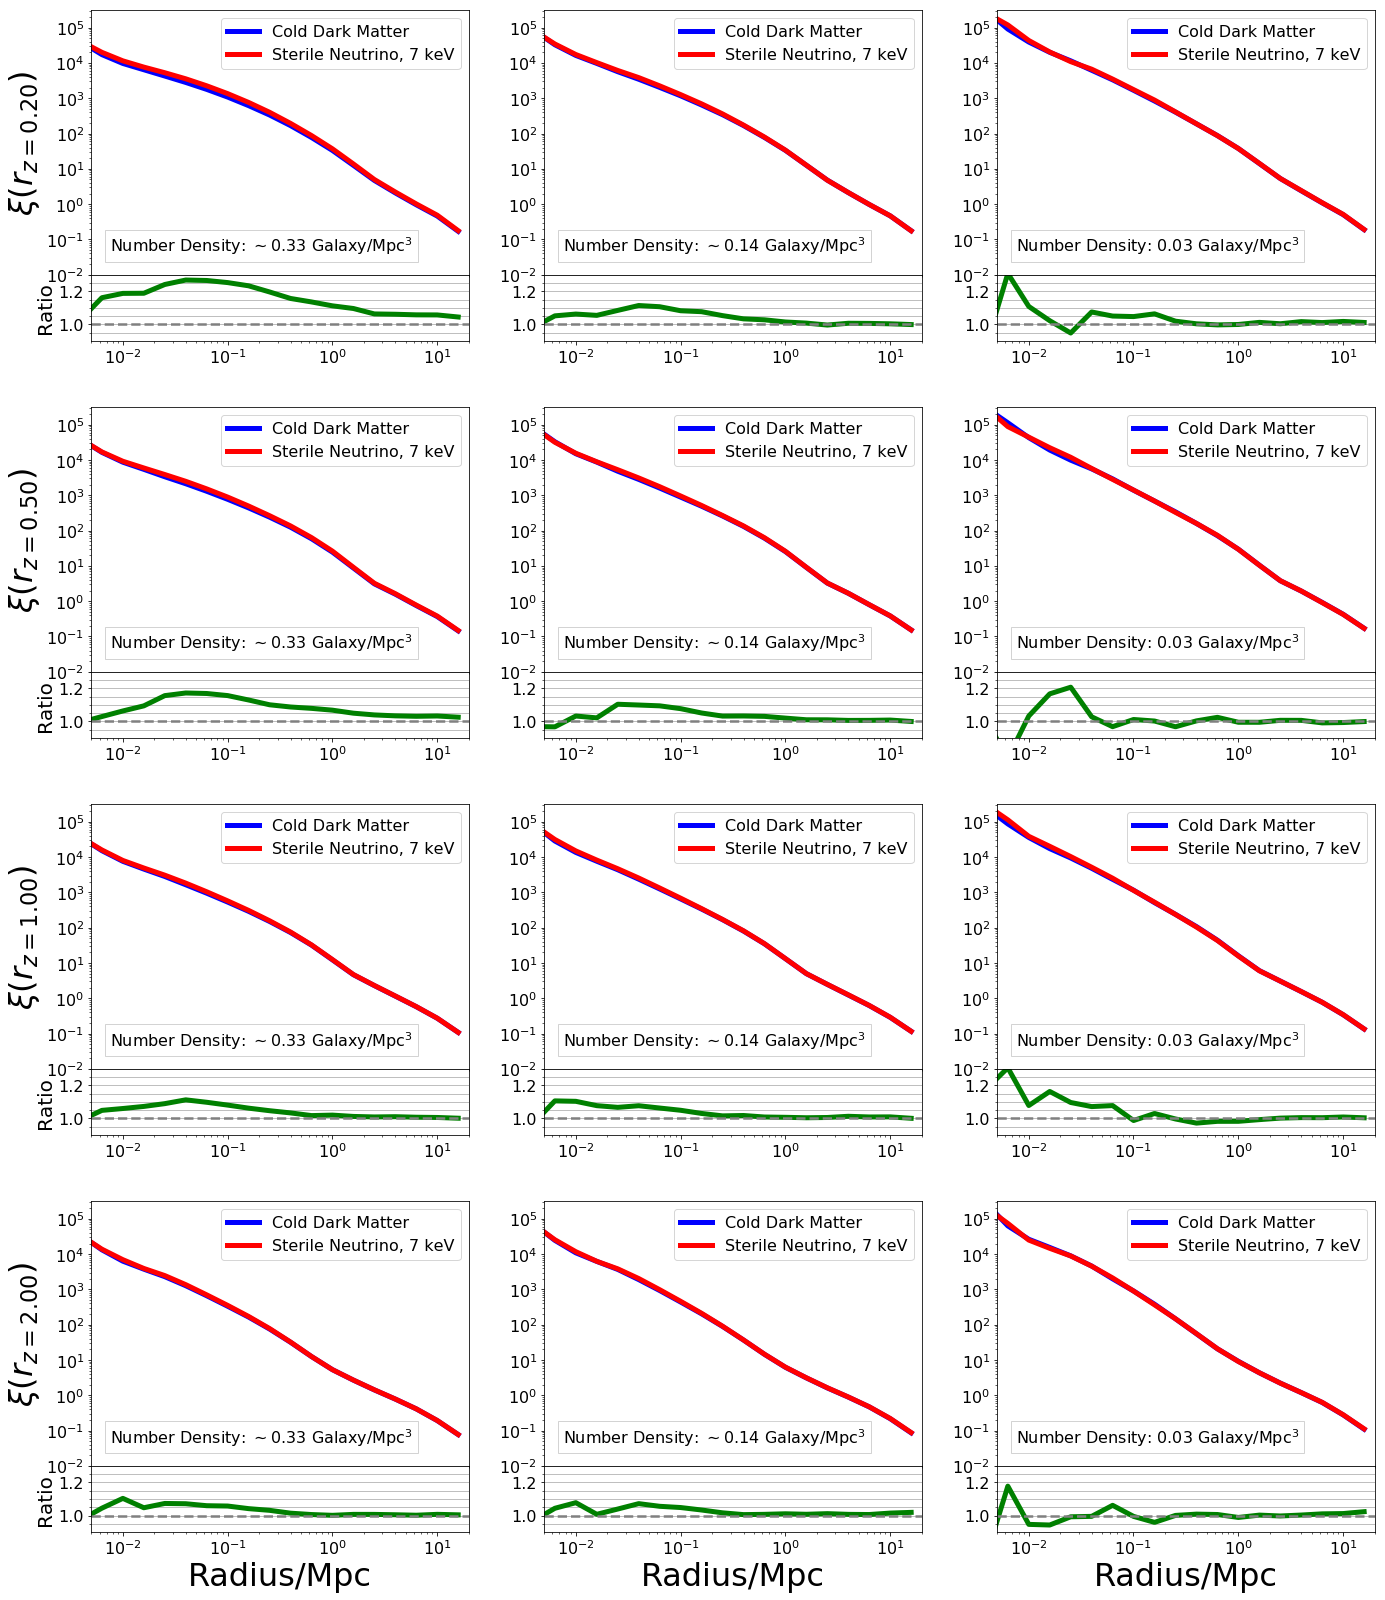

In [9]:
fig = plt.figure(figsize = (23,28)) # 30,32 #21,30 #23,28
gs = gridspec.GridSpec(4, 3)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    for n, n_text in zip([0.33,0.14,0.03],['$\sim$0.33','$\sim$0.14','0.03']):
        
        n="{:.2f}".format(n)
        
        # load data
        CUTE_cdm_sorted = np.genfromtxt("Output/redshift/corr_cdm_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_sorted = np.genfromtxt("Output/redshift/corr_wdm_galaxy_position_z"+z+"_n"+n+".txt")
        
        textstr = r'Number Density: '+n_text+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

        grid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[i], hspace=0, height_ratios=[4,1])
    
        # first grid
        grid0 = fig.add_subplot(grid[0])
        grid0.loglog(CUTE_cdm_sorted[:,0], CUTE_cdm_sorted[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid0.loglog(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid0.text(0.05, 0.15, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid0.set_ylim(10**-2, 10**5.5) #10**-1.25, 10**5.5
        grid0.legend(fontsize = 16)

        # second grid
        grid1 = fig.add_subplot(grid[1], sharex=grid0)
        grid1.semilogx(CUTE_wdm_sorted[:,0], CUTE_wdm_sorted[:,1]/CUTE_cdm_sorted[:,1], linewidth = 5, 
                       color = "green")
        grid1.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
        grid1.set_ylim(0.9, 1.3) #0.9, 1.3
        grid1.yaxis.grid(which = "both")
        
        # details
        for grid in [grid0,grid1]:
            grid.tick_params(labelsize=16)
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
        
        if (i==0)|(i==3)|(i==6)|(i==9):
            grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)
            grid1.set_ylabel("Ratio", fontsize = 20)
        if i>8:
            grid1.set_xlabel("Radius/Mpc", fontsize = 32)
        i+=1

plt.savefig('Images/Summer2020/Redshift.pdf')        
plt.show()

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide


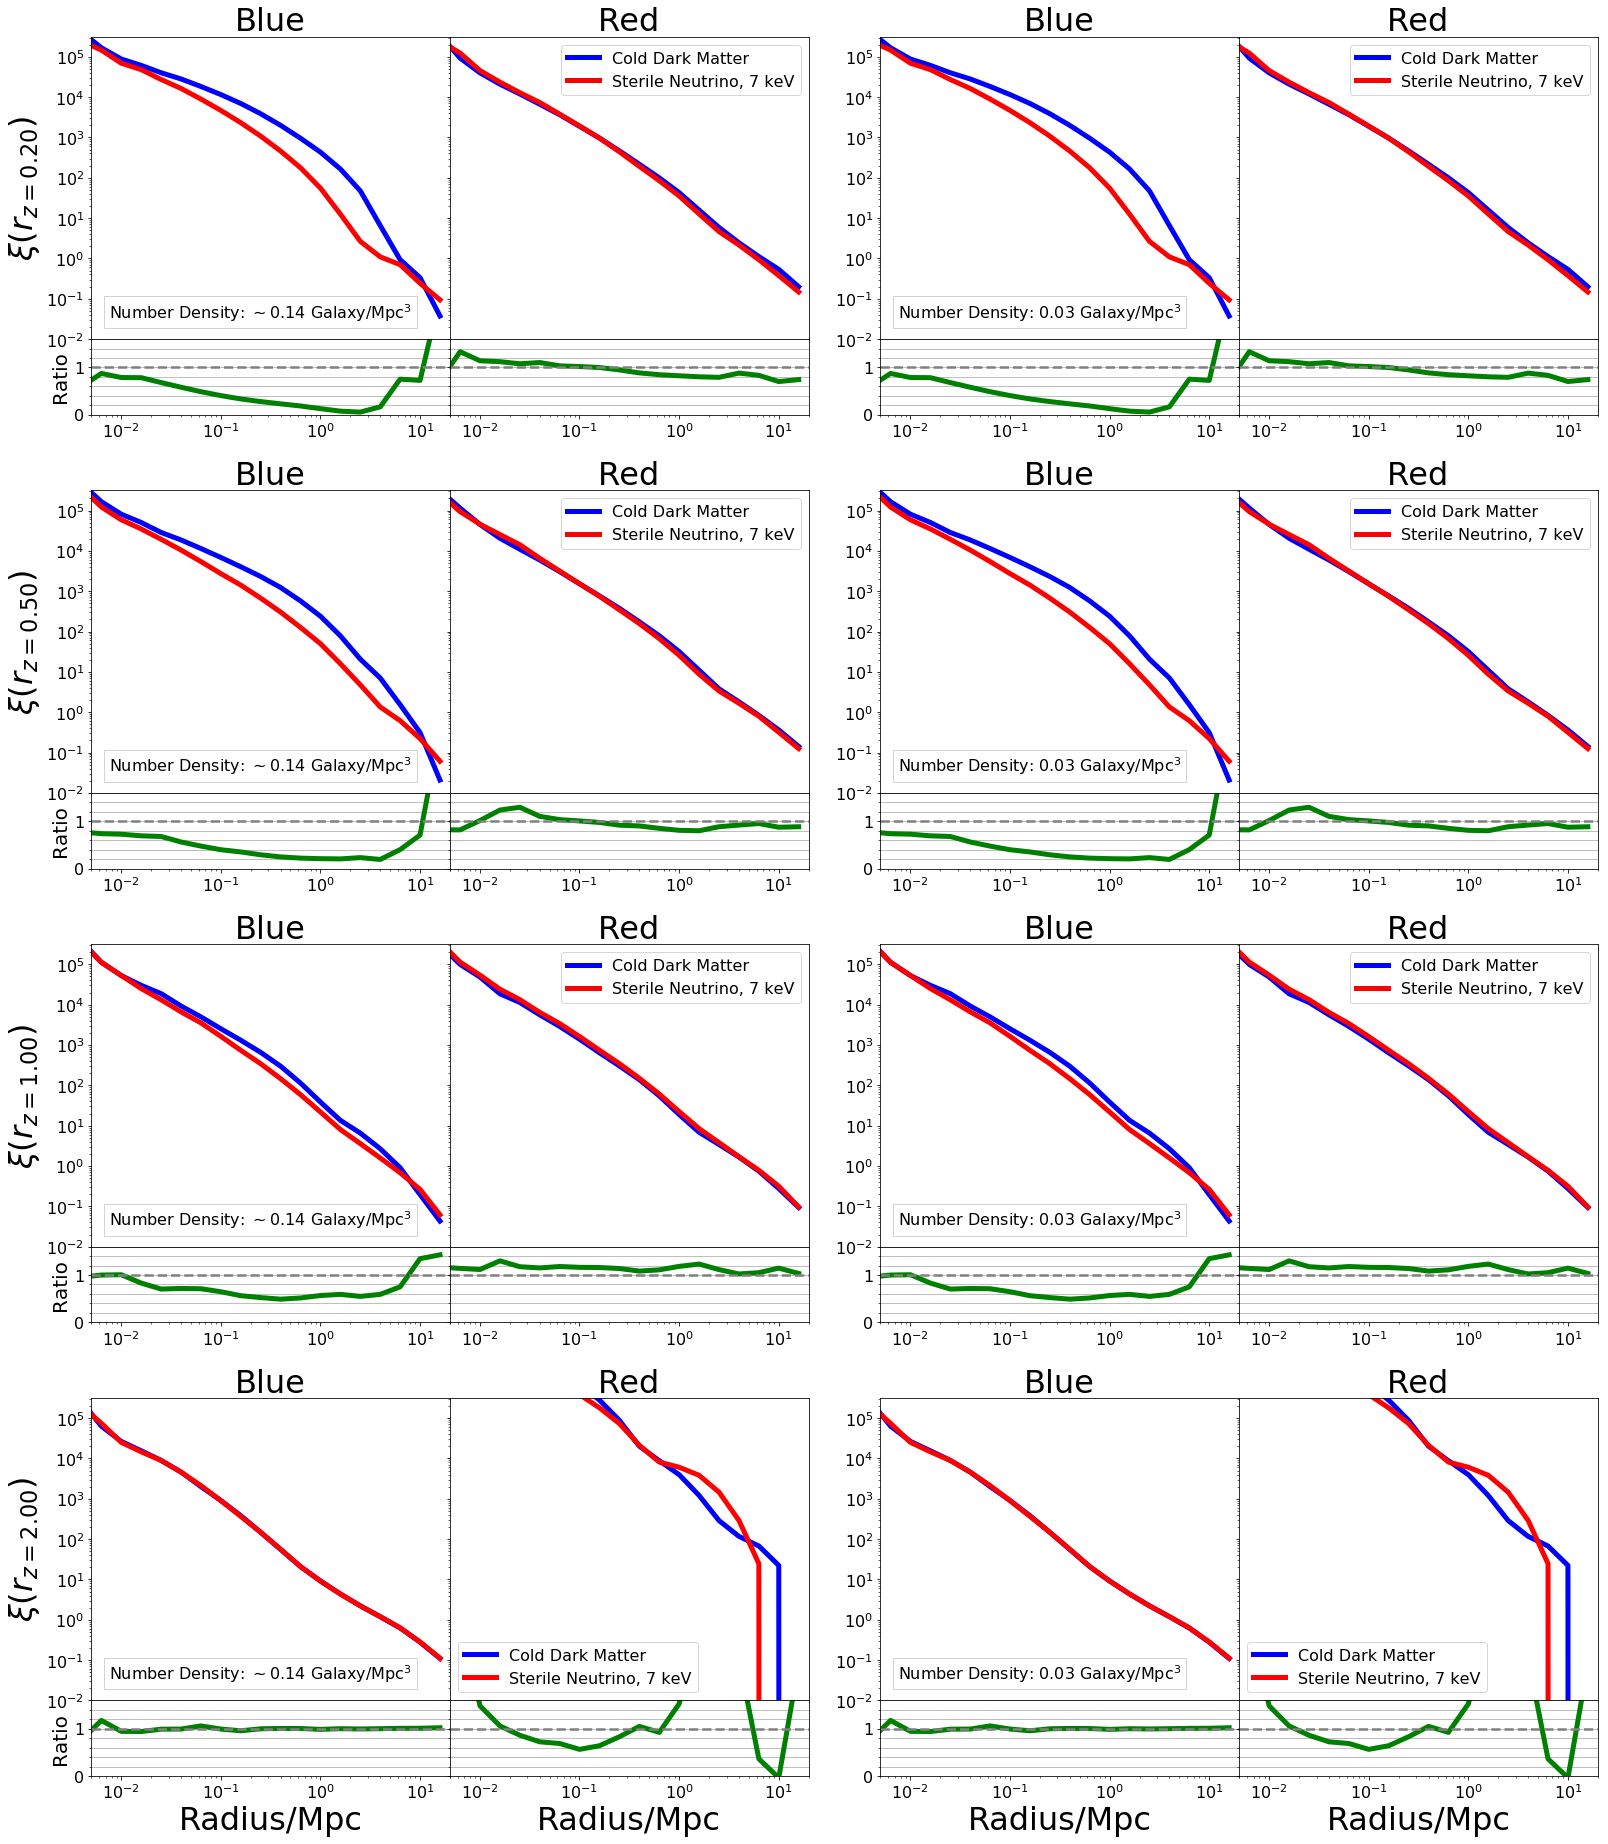

In [10]:
fig = plt.figure(figsize = (27, 32)) #28,40 #25,30
gs = gridspec.GridSpec(4, 2)

i=0
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    for n, n_text in zip([0.14,0.03],['$\sim$0.14','0.03']):
        
        n="{:.2f}".format(n)
        
        # load data
        CUTE_cdm_blue = np.genfromtxt("Output/redshift/corr_cdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_blue = np.genfromtxt("Output/redshift/corr_wdm_blue_galaxy_position_z"+z+"_n"+n+".txt")
        
        CUTE_cdm_red = np.genfromtxt("Output/redshift/corr_cdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        CUTE_wdm_red = np.genfromtxt("Output/redshift/corr_wdm_red_galaxy_position_z"+z+"_n"+n+".txt")
        
        textstr = r'Number Density: '+n_text+' Galaxy/Mpc$^{3}$'
        props = dict(facecolor='none', edgecolor='lightgrey', pad = 5.0)

        grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec = gs[i], hspace = 0, wspace = 0, 
                                                height_ratios=[4,1])
        
        # first grid
        grid0 = fig.add_subplot(grid[0])
        grid0.loglog(CUTE_cdm_blue[:,0], CUTE_cdm_blue[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid0.loglog(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid0.text(0.05, 0.125, textstr, transform = grid0.transAxes, fontsize = 16, 
                   verticalalignment = 'top', bbox=props)
        grid0.set_title('Blue',fontsize=32)
        
        # second grid
        grid1 = fig.add_subplot(grid[1])
        grid1.loglog(CUTE_cdm_red[:,0], CUTE_cdm_red[:,1], label = "Cold Dark Matter", linewidth = 5, 
                     color = "blue")
        grid1.loglog(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1], label = "Sterile Neutrino, 7 keV", 
                     linewidth = 5, color = "red")
        grid1.legend(fontsize = 16)
        grid1.set_title('Red',fontsize=32)

        # third grid
        grid2 = fig.add_subplot(grid[2], sharex=grid0)
        grid2.semilogx(CUTE_wdm_blue[:,0], CUTE_wdm_blue[:,1]/CUTE_cdm_blue[:,1], linewidth = 5, 
                       color = "green")
        
        # fourth grid
        grid3 = fig.add_subplot(grid[3])
        grid3.semilogx(CUTE_wdm_red[:,0], CUTE_wdm_red[:,1]/CUTE_cdm_red[:,1], linewidth = 5, 
                       color = "green")
        
        # details
        for grid in [grid0,grid1]:
            grid.set_ylim(10**-2, 10**5.5)
            
        for grid in [grid2,grid3]:
            grid.axhline(y = 1, color = "grey", ls = "--", linewidth = 2.5)
            grid.set_ylim(0, 1.6)
            grid.yaxis.grid(which = "both")
            
        for grid in [grid1,grid3]:
            grid.set_yticklabels([])
        
        for grid in [grid0,grid1,grid2,grid3]:
            grid.tick_params(labelsize=16)
            grid.set_xlim(5*10**-3, 2e1)
            grid.minorticks_on()
        
        if i%2==0:
            grid0.set_ylabel(r"$\xi(r_{z="+z+"})$", fontsize = 32)
            grid2.set_ylabel("Ratio", fontsize = 20)            
        if i>5:
            grid2.set_xlabel("Radius/Mpc", fontsize = 32)
            grid3.set_xlabel("Radius/Mpc", fontsize = 32)
        i+=1
    
gs.update(wspace=0.1)
plt.savefig('Images/Summer2020/Redshift_Color.pdf')   
plt.show()

# Calculate the correlation length and slope
### Define the power law function

In [11]:
def log_xi(r,r0,gamma):
    return np.log10((r/r0)**(-gamma))

In [12]:
print('Calculating the correlation length and slope...')

# loop over the redshifts
for z in [0.2,0.5,1.00,2.00]:
    
    z="{:.2f}".format(z)

    # loop over the galaxy number densities
    for n in [0.33, 0.14, 0.03]:
        
        n="{:.2f}".format(n)
        
        print('\nRedshift: z='+z+', Number density: n='+n+' Galaxy/Mpc^3')
        
        # loop over cdm and wdm
        for label in ['cdm', 'wdm']:
            
            # load data
            CUTE_sorted = np.genfromtxt("Output/redshift/corr_"+label+"_galaxy_position_z"+z+"_n"+n+".txt")

            # calculate the best fit correlation length and slope
            ydata = np.log10(CUTE_sorted[:,1])
            params = curve_fit(log_xi, CUTE_sorted[:,0][ydata!=-np.inf], ydata[ydata!=-np.inf])

            print(label.upper()+': r0='+str(params[0][0])+', gamma='+str(params[0][1]))

Calculating the correlation length and slope...

Redshift: z=0.20, Number density: n=0.33 Galaxy/Mpc^3
CDM: r0=10.134016842527265, gamma=1.3509693702426058
WDM: r0=11.556001307754793, gamma=1.3301925073434575

Redshift: z=0.20, Number density: n=0.14 Galaxy/Mpc^3
CDM: r0=8.664197571249044, gamma=1.4714795590918321
WDM: r0=8.860350079057296, gamma=1.4690464052126537

Redshift: z=0.20, Number density: n=0.03 Galaxy/Mpc^3
CDM: r0=7.535898815575757, gamma=1.6634628088087249
WDM: r0=7.338845390031486, gamma=1.6872595927800875

Redshift: z=0.50, Number density: n=0.33 Galaxy/Mpc^3
CDM: r0=8.712418646759204, gamma=1.3317189408734218
WDM: r0=8.86883776820214, gamma=1.3448381158559652

Redshift: z=0.50, Number density: n=0.14 Galaxy/Mpc^3
CDM: r0=7.052179124904643, gamma=1.5009164112598492
WDM: r0=7.347142819820914, gamma=1.4860523306306563

Redshift: z=0.50, Number density: n=0.03 Galaxy/Mpc^3
CDM: r0=6.5108273202210745, gamma=1.695030120891628
WDM: r0=6.407348631656158, gamma=1.70651098609187

C:\Users\shife\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


# Calculate the percentage of satellite galaxies
### Repeat for each model

In [13]:
print('Calculating the percentage of satellite galaxies...')

for z in [0.2,0.5,1.00,2.00]:
    
    # repeat for all redshifts
    z="{:.2f}".format(z)
    
    # iterate through each galaxy number density
    for n in [326952,136834,30000]:
        
        print('\nRedshift: z='+z+', Number density: n={:.2f}'.format(n/(100**3))+' Galaxy/Mpc^3')
        
        # loop over cdm and wdm
        for label in ['CDM', 'WDM']:
    
            galaxy = h5py.File('Data/n/home07/sbose/COLOR_'+label+'_Galaxies_z'+z+'.hdf5', 'r')

            # access galaxy mass
            galaxy_mass = galaxy['StellarMass'][:]

            # sort in order of descending mass
            ind = sorted(range(len(galaxy_mass)), key=lambda k: galaxy_mass[k], reverse = True)

            # calculate the number of satellite galaxies
            iscentral=galaxy['IsCentral'][:][ind[:n]]
            
            print(label+': '+str(len(iscentral[iscentral==0])*100/n))

Calculating the percentage of satellite galaxies...

Redshift: z=0.20, Number density: n=0.33 Galaxy/Mpc^3
CDM: 49.442119944211996
WDM: 53.03163767158482

Redshift: z=0.20, Number density: n=0.14 Galaxy/Mpc^3
CDM: 44.8930821287107
WDM: 45.60708595816829

Redshift: z=0.20, Number density: n=0.03 Galaxy/Mpc^3
CDM: 38.28
WDM: 38.12

Redshift: z=0.50, Number density: n=0.33 Galaxy/Mpc^3
CDM: 45.803971225133964
WDM: 47.942511438987985

Redshift: z=0.50, Number density: n=0.14 Galaxy/Mpc^3
CDM: 42.249002440913806
WDM: 42.90088720639607

Redshift: z=0.50, Number density: n=0.03 Galaxy/Mpc^3
CDM: 35.77
WDM: 35.52

Redshift: z=1.00, Number density: n=0.33 Galaxy/Mpc^3
CDM: 40.84513934767183
WDM: 41.851097408793954

Redshift: z=1.00, Number density: n=0.14 Galaxy/Mpc^3
CDM: 37.492874577955774
WDM: 37.97374921437655

Redshift: z=1.00, Number density: n=0.03 Galaxy/Mpc^3
CDM: 31.56
WDM: 31.263333333333332

Redshift: z=2.00, Number density: n=0.33 Galaxy/Mpc^3
CDM: 32.7928870292887
WDM: 33.48993124